## Long Short-Term Memory  

In [1]:
#%%time

In [2]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import torch.nn as nn
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import netCDF4 as nc
import xarray as xr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from source.netuno.sst_helper import SSTHelper

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
fp = 'dados/sst.mnmean.nc'

In [5]:
ds = SSTHelper.load_dataset(fp)
df = SSTHelper.load_dataframe(ds)

In [6]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [7]:
f = lambda x: ((x+180) % 360) - 180

In [8]:
df['lon'] = df['lon'].copy().apply(f)

In [9]:
df.tail()

,lat,lon,time,nbnds,time_bnds,sst
65297510,-88.0,-2.0,2023-06-01,0,9.969210e+36,NaN
65297512,-88.0,-2.0,2023-07-01,0,9.969210e+36,NaN
65297514,-88.0,-2.0,2023-08-01,0,9.969210e+36,NaN
65297516,-88.0,-2.0,2023-09-01,0,9.969210e+36,NaN
65297518,-88.0,-2.0,2023-10-01,0,9.969210e+36,NaN


In [10]:
dataset = SSTHelper.get_sst_series(df = df, lat=20, lon=-132)

In [14]:
dataset = dataset.reset_index().drop(['nbnds', 'time_bnds'], axis=1).set_index('time')

In [15]:
dataset

,sst
time,
1854-01-01,22.197483
1854-02-01,21.905436
1854-03-01,22.155600
1854-04-01,22.680405
1854-05-01,22.942524
...,...
2023-06-01,22.585289
2023-07-01,22.950830
2023-08-01,24.066349


In [16]:
from sklearn.preprocessing import MinMaxScaler

dataset = dataset.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['sst'] = scaler.fit_transform(dataset['sst'].values.reshape(-1, 1))

C:\Users\mathe\AppData\Local\Temp\ipykernel_14128\850041795.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method='ffill')


In [17]:
dataset

,sst
time,
1854-01-01,-0.090954
1854-02-01,-0.158193
1854-03-01,-0.100597
1854-04-01,0.020230
1854-05-01,0.080579
...,...
2023-06-01,-0.001668
2023-07-01,0.082491
2023-08-01,0.339321


In [18]:
def create_split_data(ts, lookback, test_start):
    data_raw = ts.to_numpy() # convercao da série para numpy
    data = []
    # laço para criar todas as combinacoes possiveis de comprimento igual a 'lookback'
    for index in range(len(data_raw) - lookback):
        # cada observaca 't' ira conter o pontos anteriores de 'lookbak'
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    # vetores para redes recorrentes possuem tres dimensoes:
    # - numero de amostras (para treino e teste)
    # - numero de passos no tempo (deinido pelo parametro 'lookback')
    # - numero de variaveis (1 para o caso de serie univariada)

    # o x e o y irao ter um deslocamento entre si de forma que cada ponto de
    # 0 ate t-1 sera utilizado para prever o ponto t
    x_train = data[:test_start, :-1, :]
    y_train = data[:test_start, -1, :]

    x_test = data[test_start:, :-1, :]
    y_test = data[test_start:, -1, :]

    # conversao para tensores pytorch
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]

In [19]:
class LSTM_base(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim):
        super(LSTM_base, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(in_features=hidden_size, out_features=output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])

        return out

In [20]:
def training_and_evaluate(model, epochs, loss_function, optimizer, X_train, y_train, X_test, verbose=True):
    # A variavel history_train e utilizada para armazenar a perda em cada epoca
    history_train = np.zeros(epochs)

    # colocar no modelo no tipo treino
    model.train()

    # o modelo sera treinado utilizando um batch, portanto, ha apenas um 
    # laço para iterar as epocas no procedimento de teste 
    for epoch in range(epochs):

        # forward pass
        y_pred = model.forward(X_train)

        # funcao perda
        loss = loss_function(y_pred, y_train)

        # o modo verboso imprime a informacao de treinamento
        if verbose:
            print(f"Epoch [{epoch + 1}|{epochs}] Loss: {loss.item()}")

        # inclui a perda da epoca atual no history_train
        history_train[epoch] = loss.item()

        # limpa o gradiente
        optimizer.zero_grad()

        # atualiza os parametros
        loss.backward()
        optimizer.step()

    # coloca o modelo em modo de validacao
    model.eval()

    # desativa o caluclo do gradiente. isso e util para procedimentos inferenciais.
    # doc.: (https://pytorch.org/docs/stable/generated/torch.no_grad.html)
    with torch.no_grad():
        # realiza predicoes para os conjuntos de treino e de teste
        y_pred_train = model.forward(X_train)
        y_pred_test = model.forward(X_test)

    return history_train, y_pred_train, y_pred_test

In [21]:
X_train, y_train, X_test, y_test = create_split_data(ts=dataset, lookback=12, test_start=1200)

In [22]:
model = LSTM_base(input_dim=1, hidden_size=64, num_layers=1, output_dim=1)

In [23]:
# funcao perda: MSE Loss
loss_function = nn.MSELoss()

# otimizadorAdam com lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

In [24]:
history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=130,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=True)

Epoch [1|130] Loss: 0.07441738992929459
Epoch [2|130] Loss: 0.07361496984958649
Epoch [3|130] Loss: 0.07279989868402481
Epoch [4|130] Loss: 0.07188771665096283
Epoch [5|130] Loss: 0.0710587203502655
Epoch [6|130] Loss: 0.07027269899845123
Epoch [7|130] Loss: 0.06942781805992126
Epoch [8|130] Loss: 0.06852900236845016
Epoch [9|130] Loss: 0.0676288828253746
Epoch [10|130] Loss: 0.06673293560743332
Epoch [11|130] Loss: 0.06579418480396271
Epoch [12|130] Loss: 0.0647810623049736
Epoch [13|130] Loss: 0.06370611488819122
Epoch [14|130] Loss: 0.06258325278759003
Epoch [15|130] Loss: 0.061380352824926376
Epoch [16|130] Loss: 0.06004234775900841
Epoch [17|130] Loss: 0.05854732543230057
Epoch [18|130] Loss: 0.05689065158367157
Epoch [19|130] Loss: 0.05502905696630478
Epoch [20|130] Loss: 0.05288456380367279
Epoch [21|130] Loss: 0.05039588361978531
Epoch [22|130] Loss: 0.047512736171483994
Epoch [23|130] Loss: 0.044148750603199005
Epoch [24|130] Loss: 0.040227118879556656
Epoch [25|130] Loss: 0.0

In [36]:
def model_performance(y_train, y_hat_train, y_test, y_hat_test):
    
    # aplica a transformacao inversa nos dados normalizados
    y_train_rev = scaler.inverse_transform(y_train.detach().numpy()).tolist()
    y_hat_train_rev = scaler.inverse_transform(y_hat_train.detach().numpy()).tolist()
    y_test_rev = scaler.inverse_transform(y_test.detach().numpy()).tolist()
    y_hat_test_rev = scaler.inverse_transform(y_hat_test.detach().numpy()).tolist()

    # calcula e obtem o RMSE
    train_RMSE = math.sqrt(mean_squared_error(y_train_rev, y_hat_train_rev))
    test_RMSE = math.sqrt(mean_squared_error(y_test_rev, y_hat_test_rev))

    print('Train score: {result} RMSE'.format(result=train_RMSE))
    print('Test score: {result} RMSE'.format(result=test_RMSE))

    # Imprime as previsoes para o conjunto de teste e os valores reais
    fig, ax = plt.subplots(figsize=(15, 2.5))
    sns.set(style="whitegrid")

    df_lines = pd.DataFrame({'Actual SST': [value for sublist in y_test_rev for value in sublist],
                             'Predicted SST': [value for sublist in y_hat_test_rev for value in sublist]})
    sns.lineplot(data=df_lines,
                 palette={'Actual SST': 'indigo', 'Predicted SST': 'deeppink'},
                 linewidth=1.5)

    plt.title('SST preditcion', fontsize=16)
    plt.xlabel('Time indicator (test set)', fontsize=12)
    plt.ylabel('SST', fontsize=12)
    plt.show()

Train score: 0.46251171677884423 RMSE
Test score: 0.39890518478361886 RMSE


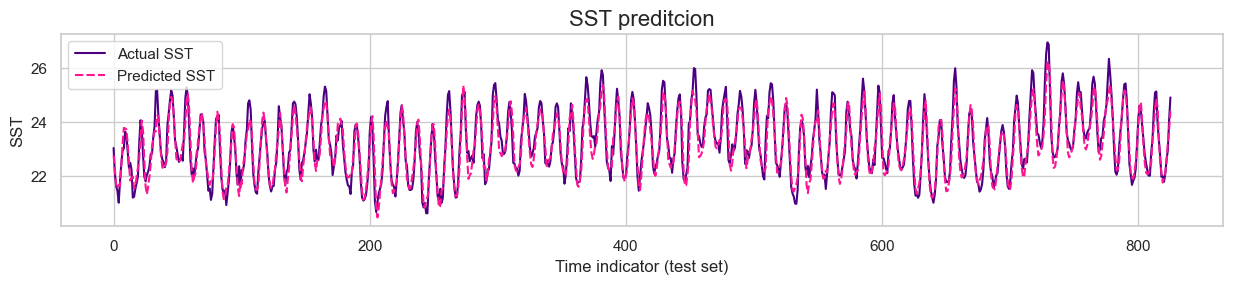

In [37]:
model_performance(y_train, y_pred_train, y_test, y_pred_test)

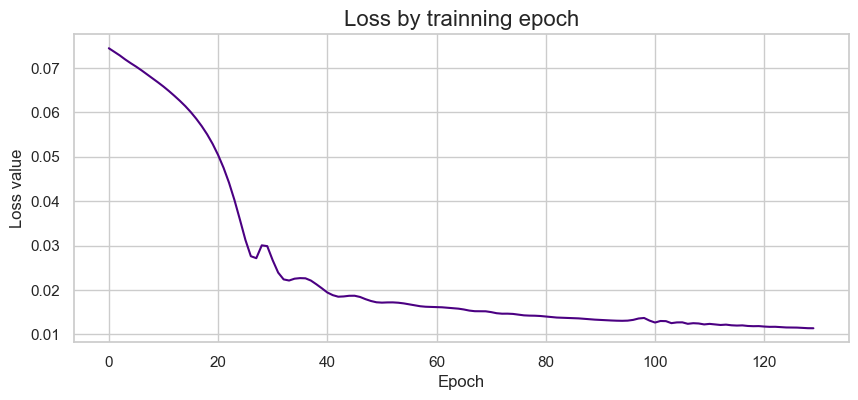

In [38]:
figure, axes = plt.subplots(figsize=(10, 4))
plt.plot(history_train, color = 'indigo')
plt.title('Loss by trainning epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss value', fontsize=12)
plt.show()